In [967]:
import matplotlib.pyplot as plt
import numpy as np

"""In order to provide a better presentation of the graphs we use the rcParams options shown below."""

import matplotlib
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [968]:
"""Our system of differential equations belongs to the complex space, that is why we implemented the code suggested in"""
"""https://stackoverflow.com/questions/19910189/scipy-odeint-with-complex-initial-values."""

import time
import numpy as np
from scipy.integrate import odeint
from scipy.special import zeta

def odeintz(func, z0, t, **kwargs):
   
    
    """An odeint-like function for complex valued differential equations.

    Inputs:
    ----------
      -func: function associated to dr/dt=f(x;t), where x is the set of parameters and variables to be determined
      -z0: 1d array with length N*(5N-1)/2
      -t: 1d array from t=0 to t=tf (parameter set by the user)
      - **kwargs: keyword arguments related with external functions to be used in odeint
    
    Return:
      -z: multivariable array with the solution of the differential equation associated with each variable"""

    # Disallow Jacobian-related arguments.
    _unsupported_odeint_args = ['Dfun', 'col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintz." % (bad_args[0],))

    # Make sure z0 is a numpy array of type np.complex128.
    z0 = np.array(z0, dtype=np.complex128, ndmin=1)

    def realfunc(x, t, *args):
        z = x.view(np.complex128)
        dzdt = func(z, t, *args)
        # func might return a python list, so convert its return
        # value to an array with type np.complex128, and then return
        # a np.float64 view of that array.
        return np.asarray(dzdt, dtype=np.complex128).view(np.float64)

    result = odeint(realfunc, z0.view(np.float64), t, **kwargs)

    if kwargs.get('full_output', False):
        z = result[0].view(np.complex128)
        infodict = result[1]
        return z, infodict
    else:
        z = result.view(np.complex128)
        return z

In [969]:
#Set of parameters

#J
#d
#epsilon
#a_cut
#gamma_du
#gamma_ud
#gamma_el

In [996]:
def g_trun(epsilon,a_cut,index_a,partial_terms):
    
    """Compute the function g explained in the main text Infinite_spin_chain.
    
    Input:
    epsilon: exponent in the inverse power law for the potential interaction.
    a_cut: cutoff value of the index a to be considered.
    index_a: first index of the two correlation operators.
    partial_terms: partial terms intended to find a better approximation.
    
    Return: value of g function with the given parameters.    """
    
    terms = [1/abs(n-index_a)**epsilon+1/abs(n+index_a)**epsilon for n in range(a_cut+1,a_cut+partial_terms+1)]
    partial_sum = sum(terms)
    
    if partial_sum<=1e-3:
        return 0
    else:
        return partial_sum


In [998]:
#J
#d
#epsilon
#a_cut
gamma_du=0.4
gamma_ud=0.2
gamma_el=1.6

gamma_plus=gamma_du/2   #gamma factor + that appears in the master equation associated to du in natural units of energy.
gamma_minus=gamma_ud/2  #gamma factor - that appears in the master equation associated to ud in natural units of energy.
gamma_z=gamma_el/8      #gamma factor z that appears in the master equation associated to el in natural units of energy.  


In [999]:
def trace(A):
    
    """Returns the trace of a square matrix
    
    Inputs:
    ----------
      -array: array associated to the matrix that we want to determine the trace
    
    Return:
      -complex: return a complex number which is the trace of the matrix of the input""" 
    
    
    return np.trace(A)  #Returns the trace of a square matrix


def matmu(A,B):
    """Perform the matrix multiplication of the matrices A and B of the form A.B
    
    Inputs:
    ----------
      -arrays: two array associated to the matrices A and B respectively
    
    Return:
      -array: array with the result of A.B or raises an error otherwise""" 
    
    return np.matmul(A,B) #Returns the result of the multiplication of matrix A and B in the order A.B

In [1000]:
rho_init0=np.array([[1/2,1/2],[1/2,1/2]])

sigma_p= np.array([[0,1],[0,0]])  #Matrix sigma+
sigma_m= np.array([[0,0],[1,0]])  #Matrix sigma-
sigma_z= np.array([[1,0],[0,-1]]) #Matrix sigmaz


##Initial values per operator

sp_init0=trace(matmu(rho_init0,sigma_p))  #initial value for sigma+
sz_init0=trace(matmu(rho_init0,sigma_z))  #initial value for sigma-
sm_init0=trace(matmu(rho_init0,sigma_m))  #initial value for sigmaz

In [1001]:
def init_vect(a_cut):
    r0=[]    
    r0.append(sz_init0)  #z initial value
    r0.append(sp_init0)
    r0.append(sz_init0**2)
    

    zp=sz_init0*sp_init0
    pp=sp_init0*sp_init0
    pm=sp_init0*sm_init0

    zp_list=[]
    pp_list=[]
    pm_list=[]

    for j in range(a_cut):
        zp_list.append(zp)
        pp_list.append(pp)
        pm_list.append(pm)

    return r0+zp_list+pp_list+pm_list    

In [1068]:
a_cut=1000
J=3
epsilon=6
d=1
partial_terms=100


#J
#d
#epsilon
#a_cut
gamma_du=0.4
gamma_ud=0.2
gamma_el=1.6

gamma_plus=gamma_du/2   #gamma factor + that appears in the master equation associated to du in natural units of energy.
gamma_minus=gamma_ud/2  #gamma factor - that appears in the master equation associated to ud in natural units of energy.
gamma_z=gamma_el/8      #gamma factor z that appears in the master equation associated to el in natural units of energy.  


def vectorsR(r, t,a_cut=a_cut,J=J,epsilon=epsilon,dist=dist):
    
    
    """Obtains the vector which summarizes the linear and non-linear elements of the differential matrix wrriten of the form
    dr/dt=G(r,t).r, where the matrix G depends of the vector that we want to simulate
    
    Inputs:
    
    Returns:
      -drdt: vector function with the different contributions from linear and non-linear terms that we require to initialize
      odeintz"""
    
    acut_list=list(range(1,a_cut+1))
    
    
    matrix_zero=np.zeros((int(3+3*a_cut),int(3+3*a_cut)),dtype = 'complex_')
    
    drdt = matrix_zero @ r   #sum of the linear and the constant part
    
    gamps=gamma_plus+gamma_minus+4*gamma_z
    gam1=3*(gamma_plus+gamma_minus)+4*gamma_z
    
    drdt[0]=2*(gamma_plus-gamma_minus)-2*(gamma_plus+gamma_minus)*r[0]  #decay
    drdt[1]= 2j*(J/(d**epsilon))*r[0]*r[1]*g_trun(epsilon,a_cut,0,partial_terms)  -gamps*r[1]
    drdt[2]= 4*(gamma_plus-gamma_minus)*r[0]-4*(gamma_plus+gamma_minus)*r[2]  #decay
    
    
    for j in range(0,a_cut):
        
        index1=int(3+a_cut+j)
        index2=int(3+2*a_cut+j)
        
        drdt[1]= drdt[1]+4j*(J/(d**epsilon))*r[3+j]/((j+1)**epsilon)
        
        
        
        drdt[3+j]= drdt[3+j]+2*(gamma_plus-gamma_minus)*r[1]-gam1*r[3+j]  #decay
        
        drdt[3+j]= drdt[3+j]+2j*(J/(d**epsilon))*( r[1]/(j+1)**epsilon +(2*zeta(epsilon)-1/(j+1)**epsilon)*(r[3+j]*r[0]+r[2]*r[1]-2*r[0]**2*r[1]   )  )
        drdt[3+j]= drdt[3+j]+2j*(J/(d**epsilon))*r[0]*( r[0]*r[1]*g_trun(epsilon,a_cut,0,partial_terms)-r[3+j]/(j+1)**epsilon )
        
        

        
        
        drdt[index1]=drdt[index1]-2*gamps*r[index1] #decay
        
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]*(1+1/2**epsilon)*r[3+j]/(j+1)**epsilon
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]**2*r[0]*(g_trun(epsilon,a_cut,0,partial_terms)+g_trun(epsilon,a_cut,j+1,partial_terms))
        drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*(2*zeta(epsilon)-1/(j+1)**epsilon)*r[0]*(r[index1]-2*r[1]**2)
        

        
        

        
        
        drdt[index2]=drdt[index2]-2*gamps*r[index2] #decay
        
        drdt[index2]=drdt[index2]-4j*(J/(d)**epsilon)*(1/2**epsilon-1)*np.real(np.conjugate(r[1])*r[3+j]/(j+1)**epsilon)
        drdt[index2]=drdt[index2]-4j*(J/(d)**epsilon)*(abs(r[1]))**2*np.real(r[0])*(g_trun(epsilon,a_cut,j+1,partial_terms)-g_trun(epsilon,a_cut,0,partial_terms))
        
        
        for w in range(1,a_cut+1):
            
            drdt[3+j]=drdt[3+j]+4j*(J/(d)**epsilon)*r[0]*r[2+w]/((w)**epsilon)
            
            if w!=j+1:
                drdt[index1]=drdt[index1]+4j*(J/(d)**epsilon)*r[1]*r[2+w]*( 1/abs(w+j+1)**epsilon+1/abs(w-(j+1))**epsilon+2/w**epsilon )
                drdt[index2]=drdt[index2]-4j*(J/(d)**epsilon)*np.real(np.conjugate(r[1])*r[2+w]*(1/abs(w+j+1)**epsilon+1/abs(w-(j+1))**epsilon-2/w**epsilon)   )   
                
        
        
        
        

   
                   
    return drdt


r0=init_vect(a_cut)



In [1069]:
init_time=0
final_time=6
steps=200


t = np.linspace(init_time, final_time, steps)

In [ ]:
import time

t0=time.time()

z=odeintz(vectorsR, r0, t)#, args=(N,L))


t1=time.time()

print(t1-t0)

In [ ]:
for j in range(3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]),label="Re"+str(j))
    plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))

In [1031]:
epsilon=4
a_cut=1
a1=0
partial_terms=100

g_trun(epsilon,a_cut,a1,partial_terms)

0.16464582990855328

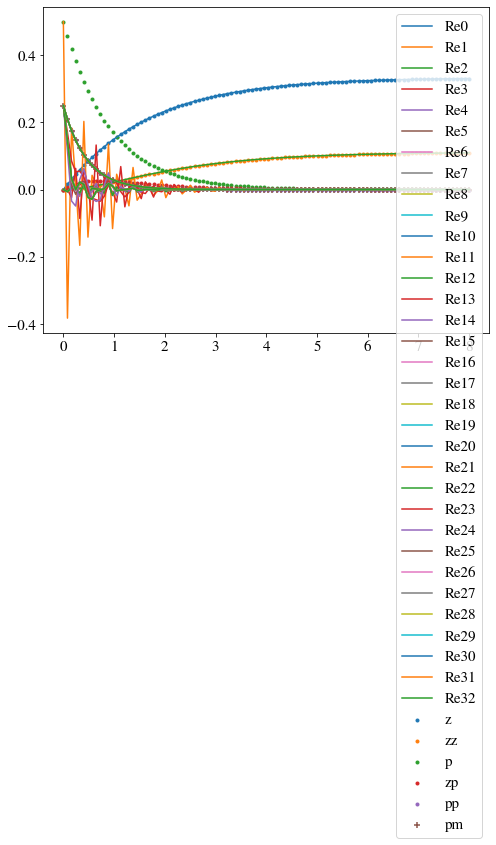

In [898]:
## Use this cell to check pure decay


for j in range(3+int(3*a_cut)):
    plt.plot(t,np.real(z[:,j]),label="Re"+str(j))
    #plt.plot(t,np.imag(z[:,j]),label="Im"+str(j))

    
def f1(t):
    return  (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus)    


def f2(t):
    return ( (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus) )**2
    
def f3(t):
    return  (1/2)*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t)   

def f4(t):
    return  (1/2)*np.exp(-(gamma_plus+gamma_minus+4*gamma_z)*t) * (gamma_plus-gamma_minus)*(1-np.exp(-2*(gamma_plus+gamma_minus)*t))/(gamma_plus+gamma_minus) 

def f5(t):
    return  f3(t)*f3(t)

def f6(t):
    return  f3(t)*f3(t)

plt.scatter(t,f1(t),marker='.', label="z")   
plt.scatter(t,f2(t),marker='.', label="zz") 
plt.scatter(t,f3(t),marker='.', label="p") 
plt.scatter(t,f4(t),marker='.', label="zp")
plt.scatter(t,f5(t),marker='.', label="pp")
plt.scatter(t,f6(t),marker='+', label="pm")
      

plt.legend()